Дан датасет с большим количеством фич, с пропусками и сильным дисбалансом целевой переменной. 
1. Работа с пропусками:
    * 1.1: Попробовал заполнить пропуски средним значением, медианным и самым часто встречающимся. В целом третий способ показал себя чуть лучше.
    * 1.2: Попробовал отфильтровать фичи с очень большим количеством пропусков. По графику "Количество отбрасываемых фич/Допустимый % пропусков" выбрал наиболее оптимальным значением в качестве допустимого процента пропусков 26%. Метрики +/- такие же, но количество фич меньше.
\
В результате я убрал из датасета фичи где больше 26% пропусков и заполнил пропуски в оставшихся самым часто встречающимся значением.
2. Масштабирование:
    * Попробовал написать алгоритм который при помощи эволюционного алгоритма (алгоритм позволяющий решить задачу полного перебора за вменяемое время) который пробовал бы применить один из скейлеров к фиче, но в результате получились довольно мусорные метрики. Данную модификацию применять не стал, оставил StandardScaler для всего датасета.
3. Корреляция:
    * Попробовал отфильтровать сильно скоррелированные фичи. Чтобы найти возможный порог построил график который показывал скорость уменьшения фич в зависимости от корреляции, график был почти линейным и ничего не показал. Померил метрики с фильтрацией фич с коэффициентом корреляции 0.75-0.95 с шагом в 0.05. В результате я получил зависимость что чем больше фич отфильтровывалось (чем ниже допустимый коэффициент корреляции) - тем ниже метрики я получал. Дальше применять данную фильтрацию я не стал
4. Балансировка целевой переменной: 
    * В исходном датасете сильно несбалансированное распределение целевой переменной (60000/1000)
    * 4.1: Попробовал выровнять датасет по минимальному количеству записей. Метрики Precision и Recall значительно повысились.
    * 4.2: Попробовал выровнять датасет путем дублирования данных с редковстречающейся целевой переменной. Метрики повысились еще больше.\
    Решил использовать методику с дублированием слабопредставленных в датасете данных.
5. Регуляризация:
    * 5.1: Использовал L1 регуляризацию для поиска важных фич. Было найдено всего 8 фич. Метрики упали
    * 5.2: Добавил генерацию PolynomialFeatures на полученных самых важных фичах. Метрики немного подросли, но всеравно они ниже чем 4.2

Лучший результат показала связка
* Фильтрация фич где больше 26% данных пропущено
* Заполнение пустых значений самыми часто встречающимися
* StandardScaler
* Дублирование слабопредставленных записей в датасете для балансировки целевой переменной 

| Accuracy | Precision | Recall   | F1       | ROC-AUC  |
|----------|-----------|----------|----------|----------|
| 0.960734 | 0.948588  | 0.972206 | 0.960252 | 0.961007 |

Сюда можно добавить одну из этих модификаций для уменьшения размерности, но результат будет ниже на 2-5%:
* Фильтр скореллированных признаков более чем на 0.8
* Фильтр через L1 регуляризацию + PolynomialFeatures

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import missingno as msno

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import roc_auc_score, mean_squared_error, \
    accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import LocalOutlierFactor
from joblib import Parallel, delayed

import category_encoders as ce

In [2]:
class StandardScalerDf(StandardScaler):
    """
    DataFrame Wrapper around StandardScaler
    http://flennerhag.com/2017-01-08-Recursive-Override/
    """
    def __init__(self, copy=True, with_mean=True, with_std=True):
        super(StandardScalerDf, self).__init__(copy=copy,
                                               with_mean=with_mean,
                                               with_std=with_std)

    def transform(self, X, y=None):
        z = super(StandardScalerDf, self).transform(X.values)
        return pd.DataFrame(z, index=X.index, columns=X.columns)

class MinMaxScalerDf(MinMaxScaler):
    """
    DataFrame Wrapper around MinMaxScaler
    """
    def __init__(self, copy=True):
        super(MinMaxScalerDf, self).__init__(copy=copy)

    def transform(self, X, y=None):
        z = super(MinMaxScalerDf, self).transform(X.values)
        return pd.DataFrame(z, index=X.index, columns=X.columns)

class RobustScalerDf(RobustScaler):
    """
    DataFrame Wrapper around RobustScaler
    """
    def __init__(self, copy=True):
        super(RobustScalerDf, self).__init__(copy=copy)

    def transform(self, X, y=None):
        z = super(RobustScalerDf, self).transform(X.values)
        return pd.DataFrame(z, index=X.index, columns=X.columns)

class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
    
class SimpleImputerDf(SimpleImputer):
    def transform(self, X, y=None):
        z = super(SimpleImputerDf, self).transform(X.values)
        return pd.DataFrame(z, index=X.index, columns=X.columns)


In [3]:
data = pd.read_csv("./to_uci/aps_failure_training_set.csv")
data

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,na,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,neg,2286,na,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,neg,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,neg,80292,na,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


In [4]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 171 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   class   object
 1   aa_000  int64 
 2   ab_000  object
 3   ac_000  object
 4   ad_000  object
 5   ae_000  object
 6   af_000  object
 7   ag_000  object
 8   ag_001  object
 9   ag_002  object
 10  ag_003  object
 11  ag_004  object
 12  ag_005  object
 13  ag_006  object
 14  ag_007  object
 15  ag_008  object
 16  ag_009  object
 17  ah_000  object
 18  ai_000  object
 19  aj_000  object
 20  ak_000  object
 21  al_000  object
 22  am_0    object
 23  an_000  object
 24  ao_000  object
 25  ap_000  object
 26  aq_000  object
 27  ar_000  object
 28  as_000  object
 29  at_000  object
 30  au_000  object
 31  av_000  object
 32  ax_000  object
 33  ay_000  object
 34  ay_001  object
 35  ay_002  object
 36  ay_003  object
 37  ay_004  object
 38  ay_005  object
 39  ay_006  object
 40  ay_007  object
 41  ay_008  object
 42  ay_00

In [5]:
data = data.replace('na', np.NaN)
target = data['class']
data = data[data.columns.drop('class')].astype(np.float64)
data['class'] = target

In [6]:
pd.set_option('max_columns', None)
data.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,755876.0,0.0,5374.0,2108.0,4114.0,12348.0,615248.0,5526276.0,2378.0,4.0,0.0,0.0,2328746.0,1022304.0,415432.0,287230.0,310246.0,681504.0,1118814.0,3574.0,0.0,0.0,6700214.0,0.0,10.0,108.0,50.0,2551696.0,97518.0,947550.0,799478.0,330760.0,353400.0,299160.0,305200.0,283680.0,NaN,NaN,NaN,178540.0,76698.08,6700214.0,6700214.0,6599892.0,43566.0,68656.0,54064.0,638360.0,6167850.0,1209600.0,246244.0,2.0,96.0,0.0,5245752.00,0.0,916567.68,6.0,1924.0,0.0,0.0,0.0,118196.0,1309472.0,3247182.0,1381362.0,98822.0,11208.0,1608.0,220.0,240.0,6700214.0,NaN,10476.0,1226.0,267998.0,521832.0,428776.0,4015854.0,895240.0,26330.0,118.0,0.0,532.0,734.0,4122704.0,51288.0,0.0,532572.0,0.0,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0,neg
1,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,99560.0,0.0,7336.0,7808.0,13776.0,13086.0,1010074.0,1873902.0,14726.0,6.0,0.0,0.0,1378576.0,447166.0,199512.0,154298.0,137280.0,138668.0,165908.0,229652.0,87082.0,4708.0,3646660.0,86.0,454.0,364.0,350.0,1393352.0,49028.0,688314.0,392208.0,341420.0,359780.0,366560.0,NaN,NaN,NaN,NaN,NaN,6700.0,33057.51,3646660.0,3646660.0,3582034.0,17733.0,260120.0,115626.0,6900.0,2942850.0,1209600.0,0.0,NaN,NaN,NaN,2291079.36,0.0,643536.96,0.0,0.0,0.0,0.0,38.0,98644.0,1179502.0,1286736.0,336388.0,36294.0,5192.0,56.0,NaN,0.0,3646660.0,NaN,6160.0,796.0,164860.0,350066.0,272956.0,1837600.0,301242.0,9148.0,22.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0,neg
2,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,1450312.0,0.0,1620.0,1156.0,1228.0,34250.0,1811606.0,710672.0,34.0,0.0,0.0,0.0,790690.0,672026.0,332340.0,254892.0,189596.0,135758.0,103552.0,81666.0,46.0,0.0,2673338.0,128.0,202.0,576.0,4.0,1234132.0,28804.0,160176.0,139730.0,137160.0,130

In [7]:
data.tail()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
59995,153002.0,NaN,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,2564.0,59100.0,1603216.0,6015982.0,1968266.0,164972.0,12560.0,4880368.0,0.0,280.0,0.0,1224.0,2114.0,8913782.0,7998174.0,1929126.0,776370.0,2.0,0.0,0.0,0.0,3328.0,1080.0,0.0,0.0,0.0,0.0,0.0,45114.0,2533260.0,2542338.0,4705948.0,0.0,7620.0,3470.0,4506.0,7466.0,60160.0,9737500.0,5938.0,0.0,0.0,0.0,3245782.0,2124728.0,917904.0,744468.0,580332.0,446850.0,496786.0,1264596.0,5214.0,0.0,10845228.0,1304.0,1206.0,1606.0,14.0,4880368.0,129760.0,1244058.0,678792.0,263320.0,221620.0,221100.0,245580.0,152420.0,212500.0,151980.0,199220.0,247880.0,153001.45,10845228.0,10845228.0,10850870.0,71618.0,64462.0,108200.0,1153820.0,9826660.0,1209600.0,243498.0,0.0,84.0,0.0,8289544.32,0.00,1529548.80,102.0,2360.0,0.0,860.0,16808.0,404890.0,3156012.0,5101686.0,1080888.0,56042.0,9214.0,260.0,224.0,574.0,10845228.0,NaN,12450.0,1270.0,138036.0,1107360.0,425276.0,5875496.0,2230222.0,36428.0,122.0,0.0,344.0,742.0,1760956.0,23486.0,0.0,146.0,0.0,0.0,1872932.0,4936.0,1600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62846.0,137050.0,27546.0,0.0,0.0,265640.0,54496.0,470800.0,293652.0,0.0,0.0,0.0,0.0,80125300.0,2912.04,2858.0,1608808.0,1479066.0,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0,neg
59996,2286.0,NaN,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0,99186.0,36564.0,128.0,0.0,0.0,56982.0,0.0,0.0,0.0,0.0,0.0,123604.0,108768.0,24020.0,11622.0,0.0,0.0,0.0,0.0,192.0,56.0,0.0,0.0,0.0,0.0,0.0,4610.0,99120.0,11292.0,20960.0,0.0,1238.0,28.0,28.0,34.0,276.0,134204.0,174.0,0.0,0.0,0.0,44228.0,60952.0,17376.0,8610.0,2990.0,1048.0,592.0,186.0,0.0,0.0,147638.0,2.0,14.0,716.0,0.0,56982.0,1900.0,14404.0,9572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23720.0,2285.92,147638.0,147638.0,150094.0,525.0,294.0,14558.0,147260.0,135982.0,1209600.0,3126.0,2.0,4.0,0.0,123344.64,0.00,11387.52,0.0,28.0,0.0,0.0,0.0,61572.0,63554.0,10126.0,602.0,128.0,0.0,0.0,0.0,6.0,147638.0,NaN,1340.0,32.0,3606.0,9664.0,2112.0,40190.0,75776.0,3066.0,196.0,0.0,330.0,214.0,123730.0,66850.0,0.0,18.0,0.0,10.0,124152.0,114.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1066.0,808.0,600.0,0.0,0.0,2450.0,510.0,823720.0,82346.0,16440.0,20.0,0.0,0.0,1285980.0,80.40,82.0,13934.0,15024.0,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0,neg
59997,112.0,0.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,11592.0,11538.0,0.0,0.0,0.0,8784.0,0.0,0.0,0.0,0.0,0.0,29698.0,23762.0,13970.0,874.0,0.0,0.0,0.0,0.0,36.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,704.0,22454.0,0.0,782.0,524.0,916.0,3940.0,924.0,13632.0,2440.0,0.0,0.0,0.0,18542.0,2236.0,856.0,490.0,162.0,424.0,234.0,158.0,20.0,36.0,43738.0,6.0,10.0,2.0,0.0,8784.0,480.0,7640.0,6224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13440.0,112.49,43738.0,43738.0,44562.0,83.0,0.0,4138.0,42880.0,23310.0,1209600.0,630.0,2.0,0.0,0.0,7518.72,422

In [8]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 171 columns):
 #   Column  Dtype  
---  ------  -----  
 0   aa_000  float64
 1   ab_000  float64
 2   ac_000  float64
 3   ad_000  float64
 4   ae_000  float64
 5   af_000  float64
 6   ag_000  float64
 7   ag_001  float64
 8   ag_002  float64
 9   ag_003  float64
 10  ag_004  float64
 11  ag_005  float64
 12  ag_006  float64
 13  ag_007  float64
 14  ag_008  float64
 15  ag_009  float64
 16  ah_000  float64
 17  ai_000  float64
 18  aj_000  float64
 19  ak_000  float64
 20  al_000  float64
 21  am_0    float64
 22  an_000  float64
 23  ao_000  float64
 24  ap_000  float64
 25  aq_000  float64
 26  ar_000  float64
 27  as_000  float64
 28  at_000  float64
 29  au_000  float64
 30  av_000  float64
 31  ax_000  float64
 32  ay_000  float64
 33  ay_001  float64
 34  ay_002  float64
 35  ay_003  float64
 36  ay_004  float64
 37  ay_005  float64
 38  ay_006  float64
 39  ay_007  float64
 40  ay_

# Target class distribution

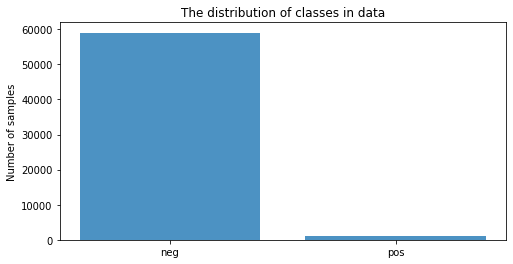

In [9]:
def class_distribution_plot(data, target):
    number_of_class_obs_dict = data.groupby(target)[target].count().to_dict()
    objects = number_of_class_obs_dict.keys()
    y_pos = np.arange(2)
    performance = list(map(lambda key: number_of_class_obs_dict[key], objects))
    plt.figure(figsize=(8,4))
    plt.bar(y_pos, performance, align='center', alpha=0.8)
    plt.xticks(y_pos, objects)
    plt.ylabel('Number of samples')
    plt.title('The distribution of classes in data')
    plt.show()
    
class_distribution_plot(data, 'class')

In [10]:
data['class'] = data['class'].apply(lambda value: 1 if value == 'pos' else 0)

# Baseline

In [11]:
def data_split_train_test(data, target, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=[target], axis=1),
    data[target],
    test_size=test_size,
    stratify=data[target],
    random_state=0)
    return X_train, X_test, y_train, y_test

In [12]:
def quality_report(prediction, actual, verbose=False):
    report_str = "Accuracy: \t {:.3f}\n" +\
                 "Precision: \t {:.3f}\n" +\
                 "Recall: \t {:.3f}\n" +\
                 "f1_score: \t {:.3f}\n" +\
                 "ROC-AUC: \t {:.3f}"
    
    acc = accuracy_score(prediction, actual)
    precision = precision_score(prediction, actual)
    recall = recall_score(prediction, actual)
    f1 = f1_score(prediction, actual)
    rocauc = roc_auc_score(prediction, actual)
    
    quality_list = [acc, precision, recall, f1, rocauc]
    
    if verbose:
        print("\n=== Quality Report ===")
        print(report_str.format(
            accuracy_score(prediction, actual),
            precision_score(prediction, actual),
            recall_score(prediction, actual),
            f1_score(prediction, actual),
            roc_auc_score(prediction, actual)
        ))
        print("======================\n")
    
    return quality_list

quality = pd.DataFrame(
    [],
    columns=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
)

In [13]:
def quality_report_of(data, scaler):
    X_train, X_test, y_train, y_test = data_split_train_test(data, 'class')
    pipeline = Pipeline([
        ('scale', scaler),
        ('log_reg', LogisticRegression(solver="liblinear"))
    ])
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    return quality_report(pred, y_test)
    

In [14]:
def make_examine(data):
    def examine(tag, feature_pipeline):
        quality.loc[tag, :] = quality_report_of(data, feature_pipeline)
    return examine

In [15]:
make_examine(data.dropna())('baseline', StandardScalerDf())
quality

,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.94382,0.913043,0.724138,0.807692,0.855358


# Missing values

In [16]:
examine = make_examine(data)
examine('fill nan with mean all values', make_pipeline(
    SimpleImputerDf(strategy='mean'), 
    StandardScalerDf()
))
examine('fill nan with median all values', make_pipeline(
    SimpleImputerDf(strategy='median'), 
    StandardScalerDf()
))
examine('fill nan with mode all values', make_pipeline(
    SimpleImputerDf(strategy='most_frequent'), 
    StandardScalerDf()
))
quality

,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.94382,0.913043,0.724138,0.807692,0.855358
fill nan with mean all values,0.990667,0.626667,0.770492,0.691176,0.882092
fill nan with median all values,0.990556,0.643333,0.753906,0.694245,0.873938
fill nan with mode all values,0.990722,0.63,0.771429,0.693578,0.882588


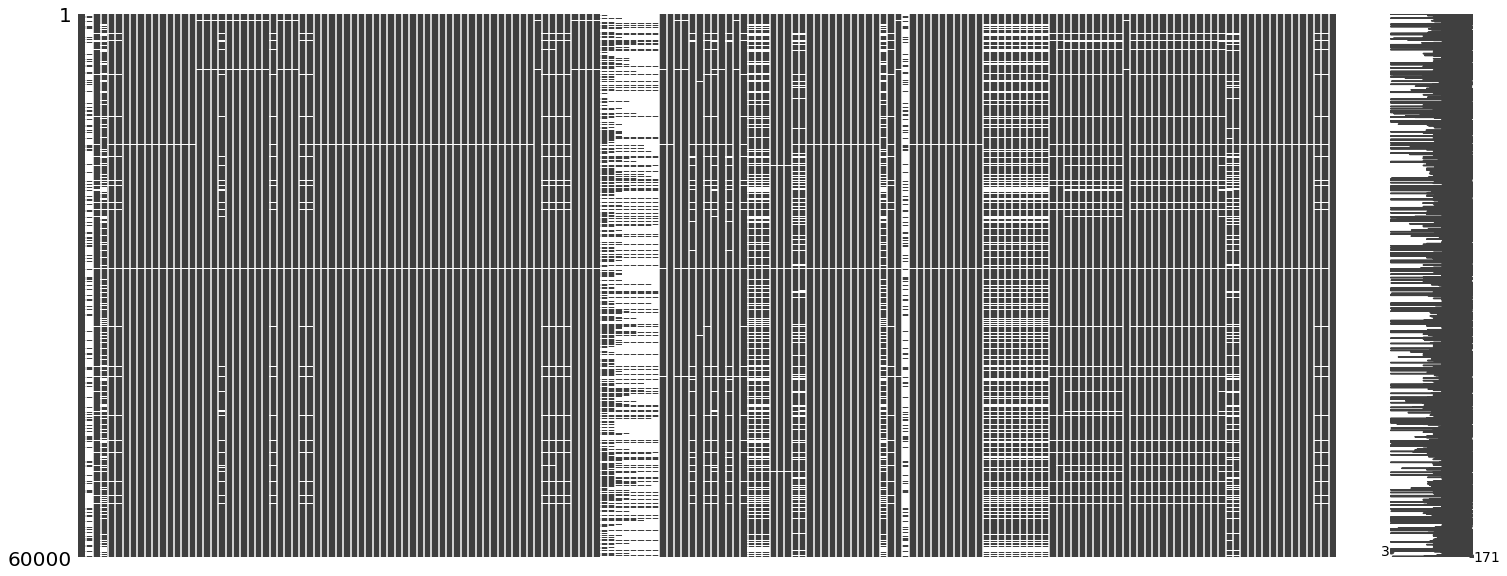

In [17]:
msno.matrix(data)

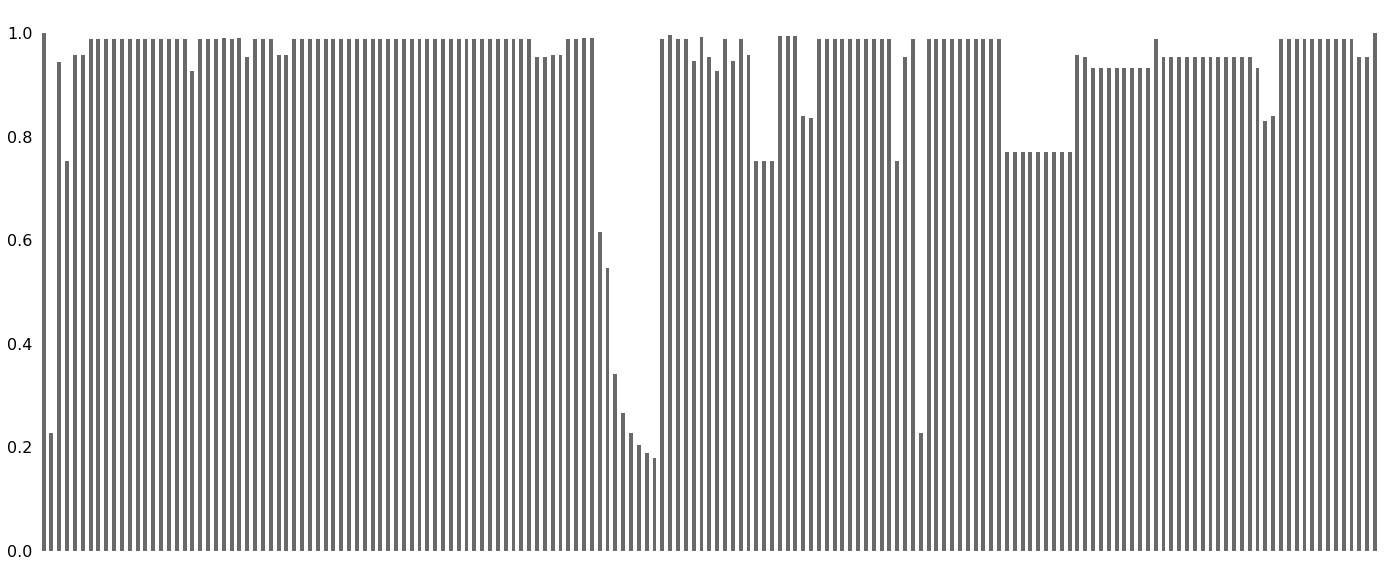

In [18]:
msno.bar(data)

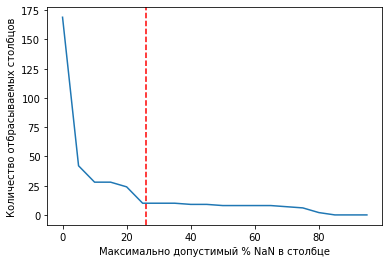

In [19]:
prct_missing = (data.isna().sum() / data.shape[0] * 100).round(2)
plt.xlabel('Максимально допустимый % NaN в столбце')
plt.ylabel('Количество отбрасываемых столбцов')
plt.axvline(x=26, color='red', linestyle='--')
plt.plot(range(0, 100, 5), [len(prct_missing[prct_missing > x]) for x in range(0, 100, 5)])

В качестве порогового значения для фильтрации столбцов с большим количеством NaN возьму 26%. Уберу все столбцы где пропусков больше.

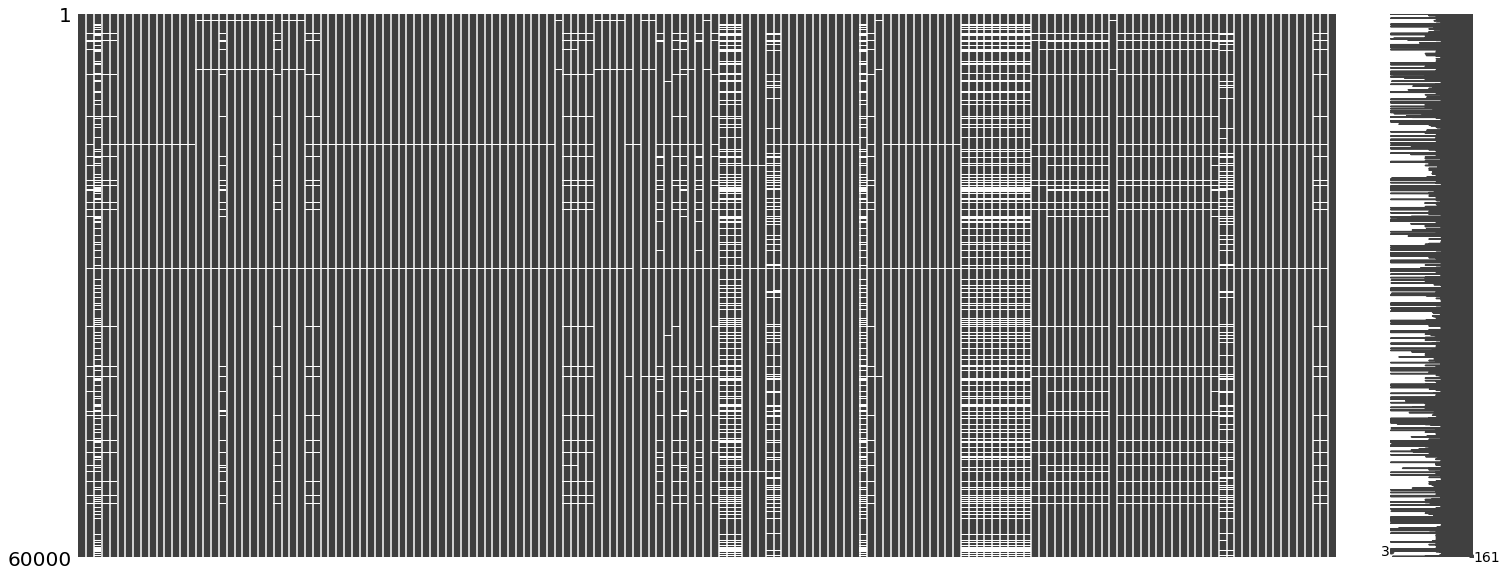

In [20]:
msno.matrix(data.drop(prct_missing[prct_missing > 26].index, axis=1))

In [21]:
examine = make_examine(data.drop(prct_missing[prct_missing > 26].index, axis=1))
examine('fill nan with mean <26% of nan', make_pipeline(
    SimpleImputerDf(strategy='mean'), 
    StandardScalerDf()
))
examine('fill nan with median <26% of nan', make_pipeline(
    SimpleImputerDf(strategy='median'), 
    StandardScalerDf()
))
examine('fill nan with mode <26% of nan', make_pipeline(
    SimpleImputerDf(strategy='most_frequent'), 
    StandardScalerDf()
))
quality

,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.94382,0.913043,0.724138,0.807692,0.855358
fill nan with mean all values,0.990667,0.626667,0.770492,0.691176,0.882092
fill nan with median all values,0.990556,0.643333,0.753906,0.694245,0.873938
fill nan with mode all values,0.990722,0.63,0.771429,0.693578,0.882588
fill nan with mean <26% of nan,0.990611,0.65,0.752896,0.697674,0.873489
fill nan with median <26% of nan,0.990667,0.653333,0.753846,0.7,0.873992
fill nan with mode <26% of nan,0.990833,0.656667,0.760618,0.70483,0.877406


Заполнение NaN повысило Accuracy и Recall, но понизило Precision. Возможно это из-за дисбаланса классов. Из заполнений лучше остальных показала себя mode

In [22]:
def make_imputer():
    return SimpleImputerDf(strategy='most_frequent')
data = data.drop(prct_missing[prct_missing > 26].index, axis=1)


# Scaling

Суть данного алгоритма в переборе разных масштабирований для каждой отдельной фичи с помощью эволюционного алгоритма.

In [23]:
from functools import partial
from sklearn.utils import shuffle

def calculate_evolution_scaler(scalers, data):
    data = data.dropna()
    value_counts = data['class'].value_counts()
    X = data.drop(['class'], axis=1)
    y = data['class']
    def scale_data(scaler):
        return scaler().fit_transform(X)
    scaled_data = dict(enumerate(map(scale_data, scalers)))
    scaled_data = { (scaler_idx, column_name): scaled_data[scaler_idx][column_name] 
    for scaler_idx in range(len(scalers)) 
    for column_name in X.columns
    }
    scaled_data = pd.DataFrame.from_dict(scaled_data)
    population_size = 100
    populations = pd.DataFrame([np.random.randint(3, size=len(X.columns)) for i in range(population_size)], columns=X.columns)
    iterations = 50
    top = populations.iloc[:1]
    def population_score(population, indexes):
        df = pd.concat([scaled_data[i][population.loc[population == i].index].loc[indexes] for i in range(len(scalers))], axis=1)
        df['class'] = y[indexes]
        X_train, X_test, y_train, y_test = data_split_train_test(df, 'class')
        lr = LogisticRegression(solver="liblinear")
        lr.fit(X_train, y_train)
        return f1_score(lr.predict(X_test), y_test)
    for i in range(iterations):
        populations['score'] = populations.apply(partial(population_score, indexes=pd.concat([data.loc[data['class'] == value].sample(np.min(value_counts.values)) for value in value_counts.index]).index), axis=1)
        populations.sort_values(by='score', ascending=False, inplace=True)
        populations.drop(['score'], axis=1, inplace=True)
        top = populations.iloc[0]
        top_result = populations.iloc[:int(population_size * 0.1)]
        mutations = populations.iloc[:int(population_size * 0.5)]
        def shuffle(data):
            d = data.values
            np.random.shuffle(d)
            return d
        shuffled_mutations = mutations.copy().apply(lambda d: d)
        def mutate_series(s1, s2):
            def mutate_values(v1, v2):
                return np.random.choice([v1, v2])
            return s1.copy().combine(s2.copy(), func=mutate_values)
        mutations = mutations.combine(shuffled_mutations, func=mutate_series)
        new = pd.DataFrame([np.random.randint(3, size=len(X.columns)) for i in range(int(population_size * 0.4))], columns=X.columns)
        populations = pd.concat([
            top_result,
            mutations,
            new
        ], ignore_index=True)
    def make_scaler(arg):
        index, scaler = arg        
        columns = top.loc[top == index].index
        return (str(index), make_pipeline(
            FunctionTransformer(lambda data: data[columns], validate=False),
            scaler()
        ))
    def make_result():
        return FeatureUnion(list(map(make_scaler, enumerate(scalers))))
    return make_result

make_scaler = calculate_evolution_scaler([StandardScalerDf, MinMaxScalerDf, RobustScalerDf], data)


/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/p

/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/p

/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/p

/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/p

/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/p

/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/p

/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/p

/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/p

/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/p

In [24]:
examine('evolution scaling', make_pipeline(
    make_imputer(), 
    make_scaler()
))
quality

/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.94382,0.913043,0.724138,0.807692,0.855358
fill nan with mean all values,0.990667,0.626667,0.770492,0.691176,0.882092
fill nan with median all values,0.990556,0.643333,0.753906,0.694245,0.873938
fill nan with mode all values,0.990722,0.63,0.771429,0.693578,0.882588
fill nan with mean <26% of nan,0.990611,0.65,0.752896,0.697674,0.873489
fill nan with median <26% of nan,0.990667,0.653333,0.753846,0.7,0.873992
fill nan with mode <26% of nan,0.990833,0.656667,0.760618,0.70483,0.877406
evolution scaling,0.9765,0.456667,0.345088,0.393113,0.667914


Судя по результатам - ерунда.

In [25]:
make_scaler = StandardScalerDf

# Correlation

In [26]:
def corr_feature_detect(data, target, threshold=0.8):
    
    corrmat = data.drop([target], axis=1).corr()

    corrmat = corrmat.abs().unstack().sort_values(ascending=False)
    
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1]
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
    correlated_feats = []

    for row in corrmat.values:
        f1, f2, corr_value = row
        if not ((f1 in correlated_feats) | (f2 in correlated_feats)):
            f1_feat_len = corrmat[(corrmat.feature1==f1) | (corrmat.feature2==f1)].shape[0]
            f2_feat_len = corrmat[(corrmat.feature1==f2) | (corrmat.feature2==f2)].shape[0]
            if f1_feat_len >= f2_feat_len:
                correlated_feats.append(f1)
            else:
                correlated_feats.append(f2)
    
    return correlated_feats

In [27]:
corr_feature_detect_threshold_range = list(range(0, 100, 5))
corr_feature_detected = [corr_feature_detect(data, 'class', x*0.01) for x in corr_feature_detect_threshold_range]

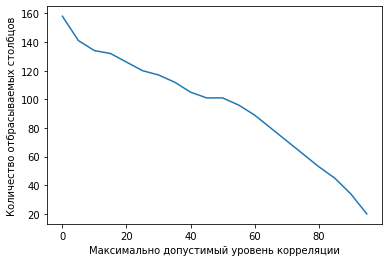

In [28]:
plt.xlabel('Максимально допустимый уровень корреляции')
plt.ylabel('Количество отбрасываемых столбцов')
plt.plot(corr_feature_detect_threshold_range, list(map(lambda x: len(x), corr_feature_detected)), label = "Алгоритм с лекции")
plt.show()

График ничего не показывает. Буду использовать 80%

In [29]:
def select_non_correlated_features(treshold):
    correlated_columns = corr_feature_detect(data, 'class', treshold)
    non_correlated_columns = data.columns.drop(correlated_columns).drop('class')
    return FunctionTransformer(lambda data: data[non_correlated_columns], validate=False)

In [30]:
examine('fill nan with mode and drop 80% correlation', make_pipeline(
    select_non_correlated_features(0.8),
    make_imputer(),
    make_scaler()
))
quality

,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.94382,0.913043,0.724138,0.807692,0.855358
fill nan with mean all values,0.990667,0.626667,0.770492,0.691176,0.882092
fill nan with median all values,0.990556,0.643333,0.753906,0.694245,0.873938
fill nan with mode all values,0.990722,0.63,0.771429,0.693578,0.882588
fill nan with mean <26% of nan,0.990611,0.65,0.752896,0.697674,0.873489
fill nan with median <26% of nan,0.990667,0.653333,0.753846,0.7,0.873992
fill nan with mode <26% of nan,0.990833,0.656667,0.760618,0.70483,0.877406
evolution scaling,0.9765,0.456667,0.345088,0.393113,0.667914
fill nan with mode and drop 80% correlation,0.989611,0.606667,0.7251,0.660617,0.859226


Метрики упали. Попробую поменять процент корреляции

In [31]:
examine('fill nan with mode and drop 75% correlation', make_pipeline(
    select_non_correlated_features(0.75),
    make_imputer(),
    make_scaler()
))
examine('fill nan with mode and drop 85% correlation', make_pipeline(
    select_non_correlated_features(0.85),
    make_imputer(),
    make_scaler()
))
quality

,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.94382,0.913043,0.724138,0.807692,0.855358
fill nan with mean all values,0.990667,0.626667,0.770492,0.691176,0.882092
fill nan with median all values,0.990556,0.643333,0.753906,0.694245,0.873938
fill nan with mode all values,0.990722,0.63,0.771429,0.693578,0.882588
fill nan with mean <26% of nan,0.990611,0.65,0.752896,0.697674,0.873489
fill nan with median <26% of nan,0.990667,0.653333,0.753846,0.7,0.873992
fill nan with mode <26% of nan,0.990833,0.656667,0.760618,0.70483,0.877406
evolution scaling,0.9765,0.456667,0.345088,0.393113,0.667914
fill nan with mode and drop 80% correlation,0.989611,0.606667,0.7251,0.660617,0.859226
fill nan with mode and drop 75% correlation,0.989222,0.57,0.724576,0.63806,0.858657


In [32]:
examine('fill nan with mode and drop 95% correlation', make_pipeline(
    select_non_correlated_features(0.95),
    make_imputer(),
    make_scaler()
))
quality

,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.94382,0.913043,0.724138,0.807692,0.855358
fill nan with mean all values,0.990667,0.626667,0.770492,0.691176,0.882092
fill nan with median all values,0.990556,0.643333,0.753906,0.694245,0.873938
fill nan with mode all values,0.990722,0.63,0.771429,0.693578,0.882588
fill nan with mean <26% of nan,0.990611,0.65,0.752896,0.697674,0.873489
fill nan with median <26% of nan,0.990667,0.653333,0.753846,0.7,0.873992
fill nan with mode <26% of nan,0.990833,0.656667,0.760618,0.70483,0.877406
evolution scaling,0.9765,0.456667,0.345088,0.393113,0.667914
fill nan with mode and drop 80% correlation,0.989611,0.606667,0.7251,0.660617,0.859226
fill nan with mode and drop 75% correlation,0.989222,0.57,0.724576,0.63806,0.858657


В целом метрики упали. Уберу фильтрацию ненужных признаков.

# Balancing

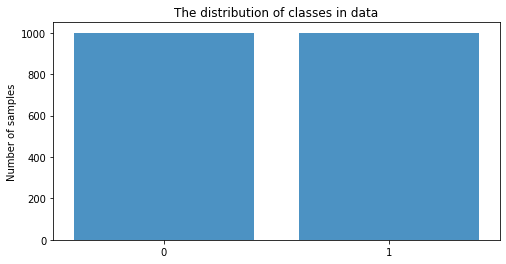

In [33]:
def get_balanced_sample(data, target):
    data_0 = data[data[target]==0]
    data_1 = data[data[target]==1]
    n = min(len(data_0), len(data_1))
    return pd.concat([data_0.sample(n=n), data_1.sample(n=n)])
class_distribution_plot(get_balanced_sample(data, 'class'), 'class')

In [34]:
make_examine(get_balanced_sample(data, 'class'))('fill nan with mode balanced', make_pipeline(
    make_imputer(), 
    make_scaler()
))
quality

,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.94382,0.913043,0.724138,0.807692,0.855358
fill nan with mean all values,0.990667,0.626667,0.770492,0.691176,0.882092
fill nan with median all values,0.990556,0.643333,0.753906,0.694245,0.873938
fill nan with mode all values,0.990722,0.63,0.771429,0.693578,0.882588
fill nan with mean <26% of nan,0.990611,0.65,0.752896,0.697674,0.873489
fill nan with median <26% of nan,0.990667,0.653333,0.753846,0.7,0.873992
fill nan with mode <26% of nan,0.990833,0.656667,0.760618,0.70483,0.877406
evolution scaling,0.9765,0.456667,0.345088,0.393113,0.667914
fill nan with mode and drop 80% correlation,0.989611,0.606667,0.7251,0.660617,0.859226
fill nan with mode and drop 75% correlation,0.989222,0.57,0.724576,0.63806,0.858657


Accuracy упал, но Precision и Recall значительно выше. Размер выборки на данный момент сильно упал (2000 из 60000), возможно стоит попробовать искусственно увеличить размер выборки путем дублирования данных.

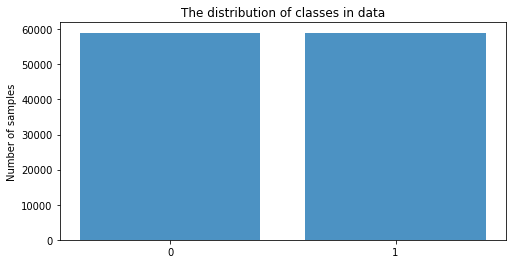

In [35]:
def get_duplicated_balanced_sample(data, target):
    data_0 = data[data[target]==0]
    data_1 = data[data[target]==1]
    n = max(len(data_0), len(data_1))
    return pd.concat([data_0.sample(n=n, replace=len(data_0)<n), data_1.sample(n=n, replace=len(data_1)<n)])
class_distribution_plot(get_duplicated_balanced_sample(data, 'class'), 'class')

In [36]:
make_examine(get_duplicated_balanced_sample(data, 'class'))('fill nan with mode balanced and duplicated', make_pipeline(
    make_imputer(), 
    make_scaler()
))
quality

,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.94382,0.913043,0.724138,0.807692,0.855358
fill nan with mean all values,0.990667,0.626667,0.770492,0.691176,0.882092
fill nan with median all values,0.990556,0.643333,0.753906,0.694245,0.873938
fill nan with mode all values,0.990722,0.63,0.771429,0.693578,0.882588
fill nan with mean <26% of nan,0.990611,0.65,0.752896,0.697674,0.873489
fill nan with median <26% of nan,0.990667,0.653333,0.753846,0.7,0.873992
fill nan with mode <26% of nan,0.990833,0.656667,0.760618,0.70483,0.877406
evolution scaling,0.9765,0.456667,0.345088,0.393113,0.667914
fill nan with mode and drop 80% correlation,0.989611,0.606667,0.7251,0.660617,0.859226
fill nan with mode and drop 75% correlation,0.989222,0.57,0.724576,0.63806,0.858657


In [37]:
make_examine(get_duplicated_balanced_sample(data, 'class'))('fill nan with mode balanced and duplicated 80% correlation filter', make_pipeline(
    select_non_correlated_features(0.80),
    make_imputer(), 
    make_scaler()
))
quality

,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.94382,0.913043,0.724138,0.807692,0.855358
fill nan with mean all values,0.990667,0.626667,0.770492,0.691176,0.882092
fill nan with median all values,0.990556,0.643333,0.753906,0.694245,0.873938
fill nan with mode all values,0.990722,0.63,0.771429,0.693578,0.882588
fill nan with mean <26% of nan,0.990611,0.65,0.752896,0.697674,0.873489
fill nan with median <26% of nan,0.990667,0.653333,0.753846,0.7,0.873992
fill nan with mode <26% of nan,0.990833,0.656667,0.760618,0.70483,0.877406
evolution scaling,0.9765,0.456667,0.345088,0.393113,0.667914
fill nan with mode and drop 80% correlation,0.989611,0.606667,0.7251,0.660617,0.859226
fill nan with mode and drop 75% correlation,0.989222,0.57,0.724576,0.63806,0.858657


Удаление скоррелированных признаков даже при сбалансированной выборке всеравно приводит к ухудшению качества

In [38]:
examine = make_examine(get_duplicated_balanced_sample(data, 'class'))

# Regularization

In [39]:
from tqdm import tqdm
def get_reg_coefs(data, penalty="l1"):
    scaled_data = Pipeline([
        ('fill_na', SimpleImputerDf(strategy='most_frequent')),
        ('passthrough', StandardScalerDf())        
    ]).fit_transform(data.drop(['class'], axis=1))
    possible_Cs = np.arange(0.001,0.2,0.01)
    coefs_values = []

    for c in tqdm(possible_Cs):
        model_LogR = LogisticRegression(C=c, penalty=penalty, solver="liblinear")
        model_LogR.fit(scaled_data, data['class'])
        coefs_values.append(model_LogR.coef_[0])
    
    return pd.DataFrame(coefs_values, columns=scaled_data.columns).sort_index(ascending=False).reset_index(drop=True)

def plot_reg_coefs(coefs_df):
    plt.figure(figsize=(12,6))
    for c in coefs_df.columns:
        plt.plot(coefs_df[c])
    plt.show()

100%|██████████| 20/20 [12:14<00:00, 36.70s/it]


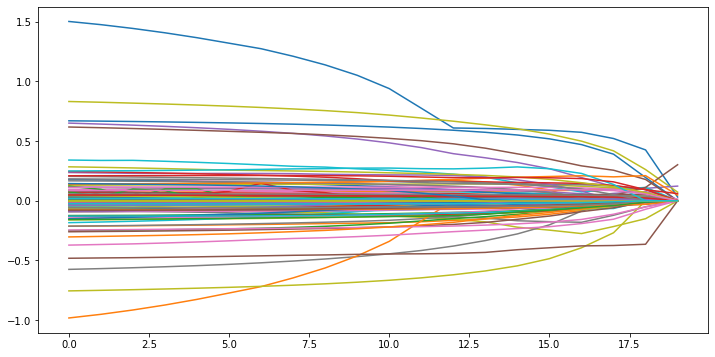

In [40]:
coefs_df_l1 = get_reg_coefs(data)
plot_reg_coefs(coefs_df_l1)

In [41]:
def get_important_features(coefs_df_l1, n_feats_limit):
    n_imp_feats = (coefs_df_l1!=0).sum(axis=1)
    index_imp_feats = n_imp_feats[n_imp_feats<=n_feats_limit].index[0]
    row_coef = coefs_df_l1.loc[index_imp_feats, :]
    return row_coef[row_coef!=0].index.tolist()

def only_important_features(limit):
    features = get_important_features(coefs_df_l1, limit)
    return FunctionTransformer(lambda data: data[features], validate=False)

In [47]:
important_features = get_important_features(coefs_df_l1, 10)
important_features

['aa_000',
 'ag_003',
 'aq_000',
 'ay_008',
 'ci_000',
 'cj_000',
 'cn_001',
 'ee_005']

In [43]:
examine('fill nan with mode and only 10 important features', make_pipeline(
    only_important_features(10),
    SimpleImputerDf(strategy='most_frequent'),
    StandardScalerDf()
))
quality

,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.94382,0.913043,0.724138,0.807692,0.855358
fill nan with mean all values,0.990667,0.626667,0.770492,0.691176,0.882092
fill nan with median all values,0.990556,0.643333,0.753906,0.694245,0.873938
fill nan with mode all values,0.990722,0.63,0.771429,0.693578,0.882588
fill nan with mean <26% of nan,0.990611,0.65,0.752896,0.697674,0.873489
fill nan with median <26% of nan,0.990667,0.653333,0.753846,0.7,0.873992
fill nan with mode <26% of nan,0.990833,0.656667,0.760618,0.70483,0.877406
evolution scaling,0.9765,0.456667,0.345088,0.393113,0.667914
fill nan with mode and drop 80% correlation,0.989611,0.606667,0.7251,0.660617,0.859226
fill nan with mode and drop 75% correlation,0.989222,0.57,0.724576,0.63806,0.858657


Оставление нескольких важных фич так же уменьшает метрики. Но с уменьшенным числом фич можно попробовать генерацию дополнительных фич через PolynomialFeatures

In [44]:
examine('fill nan with mode and only 10 important features and polynomial features', make_pipeline(
    only_important_features(10),
    SimpleImputerDf(strategy='most_frequent'),
    StandardScaler(),
    PolynomialFeatures(include_bias=True),
))
quality


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.94382,0.913043,0.724138,0.807692,0.855358
fill nan with mean all values,0.990667,0.626667,0.770492,0.691176,0.882092
fill nan with median all values,0.990556,0.643333,0.753906,0.694245,0.873938
fill nan with mode all values,0.990722,0.63,0.771429,0.693578,0.882588
fill nan with mean <26% of nan,0.990611,0.65,0.752896,0.697674,0.873489
fill nan with median <26% of nan,0.990667,0.653333,0.753846,0.7,0.873992
fill nan with mode <26% of nan,0.990833,0.656667,0.760618,0.70483,0.877406
evolution scaling,0.9765,0.456667,0.345088,0.393113,0.667914
fill nan with mode and drop 80% correlation,0.989611,0.606667,0.7251,0.660617,0.859226
fill nan with mode and drop 75% correlation,0.989222,0.57,0.724576,0.63806,0.858657


Использование полиномных фич дало незначительное увеличение метрик.